In [81]:
# GSDM - Gibbs Sampling Dirichlet Mixture Model might be better suited for short text topic modeling

"""
Well, the Gibbs Sampling Dirichlet Mixture Model (GSDMM) is an “extended” LDA algorithm, that makes the initial assumption: 1 topic is 1 document.

The words within a document are generated using the same unique topic, and not from a mixture of topics as it was in the original LDA.

GSDMM is a good choice for short text topic modeling.
"""

import numpy as np
import pandas as pd
import sys

sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim import corpora
import gensim
import re


In [82]:
data = pd.read_csv('../data/reviews_clean.csv')

In [83]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
extra_words = ["hotel", "room", "nt", "great", "location", "night", "staff",
               "stay", "day", "stayed", 'also', 'meanwhile','however', 'time',
               'hour', 'soon', 'day', 'book', 'there', 'hotel', 'room', 'leave',
               'arrive', 'place', 'stay', 'staff', 'location', 'service', 'come',
               'check', 'ask', 'lot', 'thing', 'soooo', 'add', 'rarely', 'use',
               'look', 'minute', 'bring', 'need', 'world']
stopwords.extend(extra_words)

In [84]:
for x in range(len(data)):
    data['Review_lemmatized'][x] = re.sub(r'[^\w\s]', '',  data['Review_lemmatized'][x])


    #data['Review_stopwords'][x] = data['Review_stopwords'][x].split()
    #data['Review_stopwords'][x] = [word for word in data['Review_stopwords'][x] if word not in stopwords]





C:\Users\larsb\AppData\Local\Temp\ipykernel_21176\1599761612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Review_lemmatized'][x] = re.sub(r'[^\w\s]', '',  data['Review_lemmatized'][x])


In [85]:
nltk.download('averaged_perceptron_tagger')
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in  data['Review_lemmatized']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)


# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords or bigram[1] in stopwords:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    return True



# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

# examples of bigrams


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\larsb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [86]:
# Concatenate n-grams
def replace_ngram(z):
    for gram in bigrams:
        z = z.replace(gram, '_'.join(gram.split()))
    return z


reviews_w_ngrams = data['Review_lemmatized'].copy()
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: replace_ngram(x))
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: [word for word in x.split()\
                                                 if word not in stopwords\
                                                              and len(word) > 2])

reviews_w_ngrams.head()


0    [nice, expensive, parking, got, good, deal, an...
1    [nothing_special, charge, diamond, member, hil...
2    [nice, experience, monaco, seattle, good, leve...
3    [unique, wonderful, monaco, excellent, short, ...
4    [went, seahawk, game, awesome, downfall, view,...
Name: Review_lemmatized, dtype: object

In [87]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)



In [88]:
# cast tweets to numpy array
docs = final_reviews.to_numpy()

# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(docs)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(dictionary)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

# initialize GSDMM
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=25)

# fit GSDMM model
model = mgp.fit(docs, vocab_length)

In stage 0: transferred 15772 clusters with 6 clusters populated
In stage 1: transferred 8342 clusters with 6 clusters populated
In stage 2: transferred 4849 clusters with 6 clusters populated
In stage 3: transferred 3819 clusters with 6 clusters populated
In stage 4: transferred 3400 clusters with 6 clusters populated
In stage 5: transferred 2919 clusters with 6 clusters populated
In stage 6: transferred 2717 clusters with 6 clusters populated
In stage 7: transferred 2591 clusters with 6 clusters populated
In stage 8: transferred 2407 clusters with 6 clusters populated
In stage 9: transferred 2376 clusters with 6 clusters populated
In stage 10: transferred 2338 clusters with 6 clusters populated
In stage 11: transferred 2186 clusters with 6 clusters populated
In stage 12: transferred 2116 clusters with 6 clusters populated
In stage 13: transferred 2118 clusters with 6 clusters populated
In stage 14: transferred 1966 clusters with 6 clusters populated
In stage 15: transferred 1897 clus

In [89]:
# print number of documents per topic
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(mgp.cluster_word_distribution, top_index, 20)


Number of documents per topic : [4151 2975 2935 3177 1010 6243]
Most important clusters (by number of docs inside): [5 0 3 1 2 4]

Cluster 5 : [('beach', 8445), ('resort', 8388), ('food', 7070), ('pool', 5901), ('restaurant', 4855), ('got', 3790), ('went', 3332), ('bar', 3150), ('trip', 2963), ('area', 2904), ('water', 2901), ('problem', 2467), ('breakfast', 2427), ('way', 2398), ('buffet', 2315), ('week', 2314), ('drink', 2301), ('vacation', 2255), ('going', 2020), ('bed', 1790)]

Cluster 0 : [('breakfast', 1449), ('restaurant', 1350), ('view', 1244), ('area', 1192), ('bed', 1058), ('bathroom', 1007), ('street', 931), ('price', 874), ('city', 827), ('desk', 658), ('loved', 657), ('lobby', 650), ('bar', 634), ('food', 629), ('walk', 606), ('got', 599), ('parking', 596), ('trip', 581), ('experience', 569), ('way', 557)]

Cluster 3 : [('breakfast', 1795), ('bathroom', 916), ('restaurant', 909), ('florence', 876), ('street', 714), ('area', 704), ('walk', 622), ('city', 593), ('view', 581)

In [90]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

In [91]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=docs):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(docs[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [92]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=docs)
result.head(5)



,Text,Topic,Rating,Lemma-text
0,nice hotel expensive parking got good deal sta...,type 4,4,"[parking, got, deal, arrived, evening, took, a..."
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond, member, hilton, decided, cha..."
2,nice rooms not 4* experience hotel monaco seat...,Other,3,"[experience, monaco, bathroom, mediterranean, ..."
3,"unique, great stay, wonderful time hotel monac...",type 2,5,"[monaco, stroll, downtown, shopping, area, pet..."
4,"great stay great stay, went seahawk game aweso...",Other,5,"[went, game, downfall, view, building, complai..."


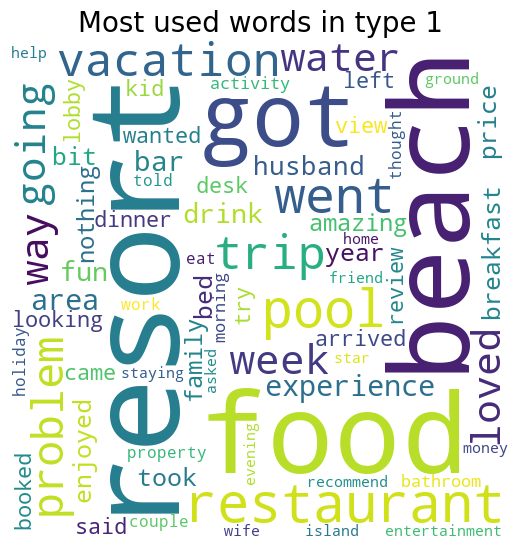

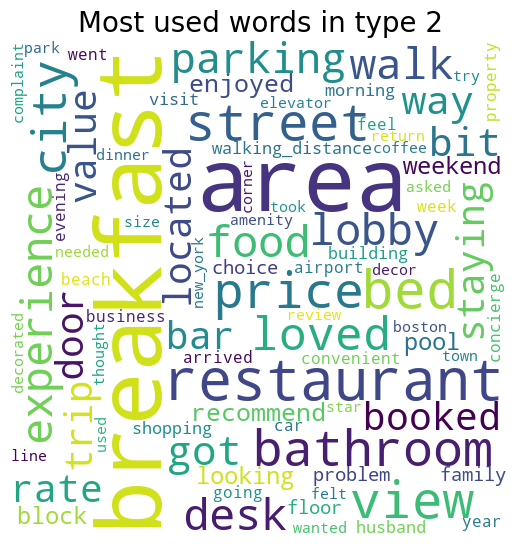

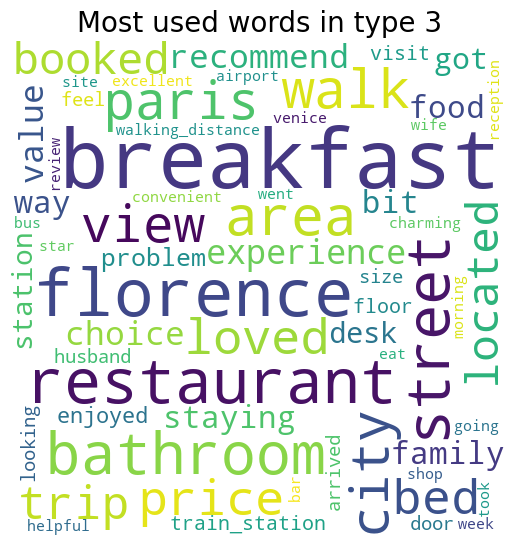

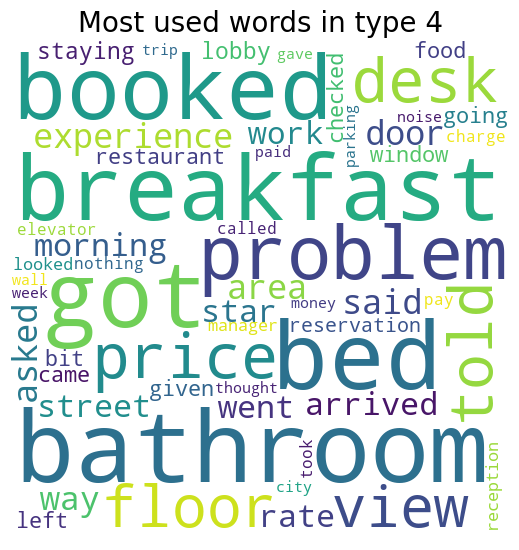

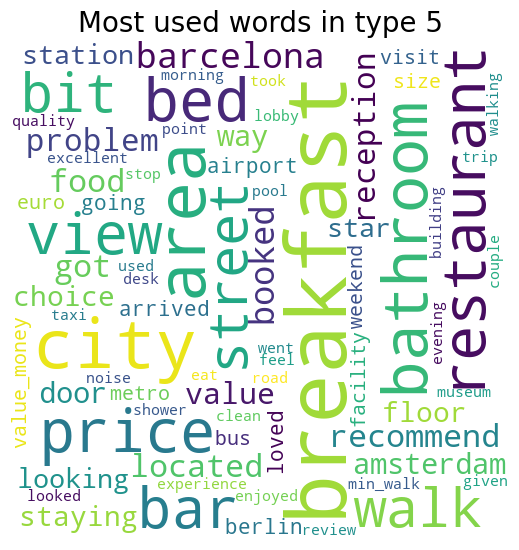

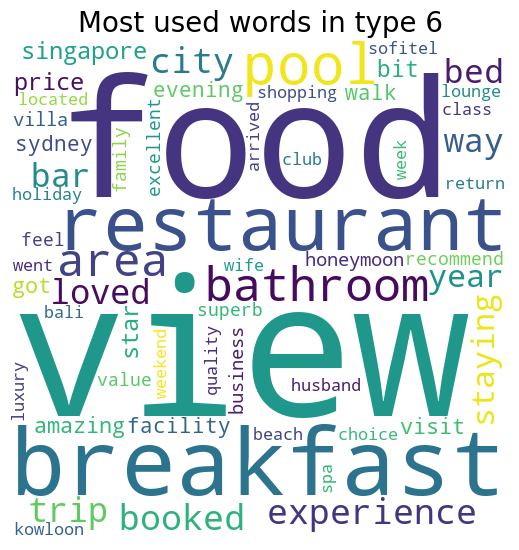

In [93]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))
result = result.drop('Lemma-text', axis=1)


# Import wordcloud library
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))

    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=20)
    plt.show()

for x in topic_names:
    create_WordCloud(result['Lemma_text'].loc[result.Topic == x], title="Most used words in " + x)


In [94]:
# This is for cohesion which isn't the easiest with GSDMM
# Take it with a grain of salt.

# import library from gensim
from gensim.models import CoherenceModel

# define function to get words in topics
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.

    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include

    '''
    # create empty list to contain topics
    topics = []

    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]

        #create empty list to contain words
        topic = []

        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)

        #append topics to topics list
        topics.append(topic)

    return topics

# get topics to feed to coherence model
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=dictionary,
                          corpus=bow_corpus,
                          texts=docs,
                          coherence='c_v')

# get coherence value
coherence_gsdmm = cm_gsdmm.get_coherence()

print(coherence_gsdmm)

0.34097709998383857
